## <center>Capstone Project: Customer Segmentation</center>

## General Libraries

In [180]:
# For data exploration, data clenaing, and visualization 
import os
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For data preprossing and feature enginnering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

 # For building model 
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
!pip install xgboost
import xgboost as xgb

# For model hyperparameter tuning 
from sklearn.model_selection import GridSearchCV

# For model evaluation 
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 1

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


## SageMaker Resources

In [181]:
# sagemaker related libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

In [182]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

## Upload Data Files to S3

In [183]:
data_dir = 'data/Input' # the Notebook folder we will use for storing data

# specify where to upload in S3
prefix = 'Arvato/Input'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-1-873710589365/Arvato/Input


In [184]:
# iterate through S3 objects and print contents
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)

Arvato/Input/DIAS Attributes - Values 2017.xlsx
Arvato/Input/DIAS Information Levels - Attributes 2017.xlsx
Arvato/Input/Udacity_AZDIAS_052018.csv
Arvato/Input/Udacity_CUSTOMERS_052018.csv
Arvato/Input/Udacity_MAILOUT_052018_TEST.csv
Arvato/Input/Udacity_MAILOUT_052018_TRAIN.csv
Arvato/Output/pca-2020-10-24-22-10-29-809/output/model.tar.gz
Arvato/Output/pca-2020-10-24-23-58-19-122/output/model.tar.gz
Arvato/Output/pca-2020-10-25-01-16-34-554/output/model.tar.gz
counties/pca-2020-10-25-02-25-01-313/output/model.tar.gz
sagemaker-record-sets/PCA-2020-10-24-22-06-26-226/.amazon.manifest
sagemaker-record-sets/PCA-2020-10-24-22-06-26-226/matrix_0.pbr
sagemaker-record-sets/PCA-2020-10-24-22-10-07-015/.amazon.manifest
sagemaker-record-sets/PCA-2020-10-24-22-10-07-015/matrix_0.pbr
sagemaker-record-sets/PCA-2020-10-24-23-57-49-046/.amazon.manifest
sagemaker-record-sets/PCA-2020-10-24-23-57-49-046/matrix_0.pbr
sagemaker-record-sets/PCA-2020-10-25-01-15-08-555/.amazon.manifest
sagemaker-record-set

# Part 1: Data Exploration, Cleaning, and Visualization

## Data Exploration

###  Load attribute value dataset

* attribute_values - includes a description of columns in azdias and customers data, information about range of values each column can take and their respective meanings

In [21]:
# Read attribute values for a first try
attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1)
attributes_values

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
...,...,...,...,...,...
2253,NaN,NaN,NaN,2,smart
2254,NaN,NaN,NaN,3,fair supplied
2255,NaN,NaN,NaN,4,price driven
2256,NaN,NaN,NaN,5,seeking orientation


In [22]:
# Check for NaN info of each column 
attributes_values.isnull().sum()

Unnamed: 0     2258
Attribute      1944
Description    1907
Value             0
Meaning          11
dtype: int64

* "Unnamed" column is just an empty one with all "NaN" so we can ignore it while loading data 

In [23]:
# Reload attribute values but ignoring "Unnamed" column 
no_unamed = lambda x: 'Unnamed' not in x
attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
...,...,...,...,...
2253,NaN,NaN,2,smart
2254,NaN,NaN,3,fair supplied
2255,NaN,NaN,4,price driven
2256,NaN,NaN,5,seeking orientation


In [24]:
attributes_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Value        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB


* We can replace "unknown" values with "np.nan" values

### Load attribute information dataset

* attribute_info - includes detailed information about each column with additional notes 

In [25]:
# Read attribute information
attributes_info = pd.read_excel('./data/Input/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)
attributes_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [26]:
attributes_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  10 non-null     object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB


### Load "azdias" and "customers" datasets

In [27]:
azdias = pd.read_csv('./data/Input/Udacity_AZDIAS_052018.csv', sep=';', usecols=no_unamed)
azdias

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290394,531253,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0
290395,531261,-1,9.0,18.0,NaN,NaN,NaN,NaN,18.0,17.0,...,4.0,8.0,10.0,7.0,6.0,9.0,3.0,5.0,1.0,2.0
290396,531267,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,35.0,...,3.0,7.0,10.0,8.0,5.0,9.0,4.0,5.0,1.0,1.0
290397,531268,-1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,35.0,...,3.0,8.0,10.0,7.0,NaN,7.0,4.0,3.0,1.0,4.0


In [28]:
print("Azdias shape -",azdias.shape)
print("Azdias columns -",azdias.columns)

Azdias shape - (290399, 366)
Azdias columns - Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)


In [29]:
# Take a look at the columns with warning
print(azdias.columns[18:20])
warning_cols = list(azdias.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [30]:
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown


In [31]:
#attributes_values.head(500)

In [32]:
# "CAMEO_INTL_2015" ---> named as "CAMEO_DEUINTL_2015" in attribute values excel sheet
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUINTL_2015"]

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [33]:
azdias[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290399 entries, 0 to 290398
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  258798 non-null  object
 1   CAMEO_INTL_2015  258798 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [34]:
azdias[warning_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [35]:
azdias[warning_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [36]:
customers = pd.read_csv('./data/Input/Udacity_CUSTOMERS_052018.csv', sep=';',usecols=no_unamed)
customers

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,5.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
191648,154563,-1,2.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,4.0,NaN,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,2,4
191649,148813,2,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,...,5.0,3.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
191650,148852,3,1.0,13.0,NaN,NaN,NaN,NaN,13.0,4.0,...,1.0,4.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,2,3


In [37]:
print("Customers shape -",customers.shape)
print("Customers columns -",customers.columns)

Customers shape - (191652, 369)
Customers columns - Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=369)


In [38]:
print(customers.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [39]:
customers[warning_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [40]:
customers[warning_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

* By observing Column 18 and Column 19 ('CAMEO_DEUG_2015', 'CAMEO_INTL_2015') in both of "azdias" and "customers" datasets, we have: 
- 'X' and 'XX' values that does not show in the given description in the attributes_values dataset
- 'NaN' values
-  data types are mixed with 'strings' and 'floats' so we will convert them into integers

In [41]:
def change_cameo_cols(df):
    """
    A function to replace 'X', 'XX' with 'np.nan' in 
    columns 18 and 19 ('CAMEO_DEUG_2015', 'CAMEO_INTL_2015') and 
    convert data types to integers    
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [42]:
azdias = change_cameo_cols(azdias)
customers = change_cameo_cols(customers)

In [43]:
azdias[warning_cols[1]].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [44]:
customers[warning_cols[1]].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

### Check for the difference of provided attributes between datasets

In [45]:
# Check the difference between azdias and customers datasets 
extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in customers dataset - ", extra_cols_in_customers)

Extra columns in customers dataset -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [46]:
attributes_list  = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)
print("List of attributes: \n", attributes_list)
print("List of azdias attributes: \n", azdias_list)
print("List of customers attributes: \n",customers_list)

List of attributes: 
 ['AGER_TYP', nan, 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_

In [47]:
attribute_list = set(attributes_list)
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_attributes_vs_customers = (set(attributes_list) - set(customers_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))
common_customers_attributes = (set(customers_list) & set(attributes_list))

print("Number of columns for attributes: ", str(len(attribute_list)))
print("Number of columns common to all 3 datasets: ", str(len(common_to_all)))
print("Number of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("Number of columns common between customers and attributes: " + str(len(common_customers_attributes)))
print("Number of columns specific to attributes: " + str(len(unique_to_attributes)))
print("Number of columns specific to azdias: " + str(len(unique_to_azdias)))
print("Number of columns specific to customers: " + str(len(unique_to_customers)))
print("Number of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("Number of columns exclusive to attributes vs customers: " + str(len(unique_to_attributes_vs_customers)))

Number of columns for attributes:  315
Number of columns common to all 3 datasets:  272
Number of columns common between azdias and attributes: 272
Number of columns common between customers and attributes: 272
Number of columns specific to attributes: 43
Number of columns specific to azdias: 0
Number of columns specific to customers: 3
Number of columns exclusive to attributes vs azdias: 43
Number of columns exclusive to attributes vs customers: 43


* We have 43 unique columns given in the attribute values that are not present in azdias or customer datasets. This might be due to errors in recording these columns. We can consider to correct these mistakes and analysing what is the reason behind these missing columns. However, in this analysis we are going to neglect this information and consider only the 272 columns which are common to all three dataframes to replace the 'unkown' values.

## Data Cleaning

### Fix several data columns

* We start to go through some columns and verify what values they represent and clean them to contain values that are given in the attribute information data.

In [48]:
# Check for NaN info of each column 
azdias.isnull().sum()

LNR                                 0
AGER_TYP                            0
AKT_DAT_KL                      23566
ALTER_HH                        23566
ALTER_KIND1                    263714
ALTER_KIND2                    280658
ALTER_KIND3                    288341
ALTER_KIND4                    290005
ALTERSKATEGORIE_FEIN            85524
ANZ_HAUSHALTE_AKTIV             29898
ANZ_HH_TITEL                    31157
ANZ_KINDER                      23566
ANZ_PERSONEN                    23566
ANZ_STATISTISCHE_HAUSHALTE      29898
ANZ_TITEL                       23566
ARBEIT                          31260
BALLRAUM                        30063
CAMEO_DEU_2015                  31601
CAMEO_DEUG_2015                 31717
CAMEO_INTL_2015                 31717
CJT_GESAMTTYP                    1609
CJT_KATALOGNUTZER                1609
CJT_TYP_1                        1609
CJT_TYP_2                        1609
CJT_TYP_3                        1609
CJT_TYP_4                        1609
CJT_TYP_5   

* Staring with columns LP_FAMILIE_*, LP_FAMILIE_*, and LP_LEBENSPHASE_*, since the have some strange values that have not been specified in the attribute description.

In [49]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_FEIN.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

[ 2.  5.  1.  0. 10.  7. 11.  3.  8.  4.  6. nan  9.]
[ 2.  3.  1.  0.  5.  4. nan]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
[ 1.  2.  4.  5.  3. nan]
[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
[ 4.  6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8. nan]


In [50]:
attributes_values[attributes_values["Attribute"] == "LP_FAMILIE_FEIN"]

,Attribute,Description,Value,Meaning
1892,LP_FAMILIE_FEIN,familytyp fine,1,single


In [51]:
attributes_values[attributes_values["Attribute"] == "LP_FAMILIE_GROB"]

,Attribute,Description,Value,Meaning
1903,LP_FAMILIE_GROB,familytyp rough,1,single


In [52]:
attributes_values[attributes_values["Attribute"] == "LP_LEBENSPHASE_FEIN"]

,Attribute,Description,Value,Meaning
1914,LP_LEBENSPHASE_FEIN,lifestage fine,1,single low-income earners of younger age


In [53]:
attributes_values[attributes_values["Attribute"] == "LP_LEBENSPHASE_GROB"]

,Attribute,Description,Value,Meaning
1954,LP_LEBENSPHASE_GROB,lifestage rough,1,single low-income- and average earners of youn...


Note: The columns LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, and LP_LEBENSPHASE_GROB contain "0" as an entry which does not correspond to any category as the per the values information given in attribute values. For this reason, any 0 in these columns can be converted to nan.

In addition, some columns contain information that needs to be restructed: 
* 1: LP_FAMILIE_FEIN and LP_STATUS_FEIN give a fine categorization of the family type and family status. The same information in a broader spectrum is given by LP_FAMILIE_GROB and LP_STATUS_GROB. For this reason, for this analysis the columns LP_FAMILIE_FEIN and LP_STATUS_FEIN will be dropped. (Not in the function below but at a later stage when all the unwanted columns are removed at once for simplicity)
* 2: LP_LEBENSPHASE_GROB gives overall description of the life stage the person is in with respect to age and wealth while LP_LEBENSPHASE_FEIN gives a fine categorization of the persons age and financial status. Terefore, these two columns represent same information twice. Therefore, LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN are restructed so that one of them contains information about age and the other one contains information about wealth.

In [54]:
def restructure_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [55]:
customers = restructure_LP_cols(customers)
azdias = restructure_LP_cols(azdias)

In [56]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_FEIN.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

[ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
[ 1.  2.  0. nan]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
[ 0.  1. nan]
[ 3.  2.  1. nan  4.]
[ 1.  2. nan  3.  4.]


* Next step, column EINGEFUEGT_AM seems to tell about the date on which the entry was made. Althoug there is no specific description given about this column, this can be converted ito a datetime object to see its distribution.

In [57]:
def change_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [58]:
customers = change_eigefugt_col(customers)
azdias = change_eigefugt_col(azdias)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


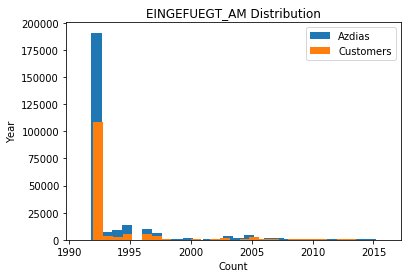

In [59]:
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
plt.ylabel("Year")
plt.xlabel("Count")
plt.title("EINGEFUEGT_AM Distribution")
plt.legend()
plt.show()

* Seems like the distributions are almost similar. 

* We can further analyse and change other categorical columns after making sure all the unkown values are replaced with NaNs in the dataframes.

### Addressing Unkown Values

From the information given in the attributes-values dataframe, some columns have unkown values recorded with specific representations. These unkown representations can be obtained by the following steps. We can later use these representations to change them to NaN values, by treating them as missing entries.

In [60]:
unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


Note: we have 232 columns which have unkown values, as displayed below. These values in the columns need to be replaced with NaN values.

In [61]:
unkown_attributes_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown


In [62]:
unkown_attributes_values = unkown_attributes_values.dropna()

In [63]:
def get_unkown_representation(attrib, unkown_attributes_values):
    """Returns the representation of unkown values"""
    
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]

    return [unkown]

In [64]:
ager_typ_unknown = get_unkown_representation("AGER_TYP", unkown_attributes_values)

print(ager_typ_unknown)

[[-1]]


* The second column 'AGER_TYP' has a lot of -1s which correspond to unkown values. To convert all these values into np.nan values we first have to get the value which corresponds to unkown value from the attribute_value data and then replace these values.

In [65]:
def replace_unkown_with_nan(val, unkown):
    """Replaces unkown values with np.nan values if the value mathes with the unkown representation"""
    if val in unkown:
        return np.nan
    else:
        return val

In [66]:
azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(replace_unkown_with_nan, args=(ager_typ_unknown))

In [67]:
azdias

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,15.0
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,21.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,NaN
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290394,531253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0,NaN
290395,531261,NaN,9.0,18.0,NaN,NaN,NaN,NaN,18.0,17.0,...,8.0,10.0,7.0,6.0,9.0,3.0,5.0,1.0,2.0,1.0
290396,531267,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,35.0,...,7.0,10.0,8.0,5.0,9.0,4.0,5.0,1.0,1.0,4.0
290397,531268,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,35.0,...,8.0,10.0,7.0,NaN,7.0,4.0,3.0,1.0,4.0,NaN


* We can repeat the same thing for all the other columns with unkown values.

In [68]:
def replace_unkowns(df, unkown_attributes_values, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_representation(attrib, unkown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unkown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [69]:
azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

In [70]:
customers = replace_unkowns(customers, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

### Missing Values

* Now that we have replaced all the unkowns to np.nan so we can now look at how many missing values each column contains and decide whether to keep a column for further analysis.

#### Missing values Column-wise

In [71]:
def get_missing_report(df):
    """
    Takes in a dataframe and returns a dataframe with information about column-wise missing values percentages.
    """
    missing_percen = df.isna().sum() * 100/ len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

In [72]:
customer_missing_report = get_missing_report(customers)
azdias_missing_report = get_missing_report(azdias)

In [73]:
print("Total Number of columns in Customers - ", len(customers.columns))
print("Number of columns with missing values in customers - ",
      len(customer_missing_report[customer_missing_report.Missing_Percentage > 0]))

print("Total Number of columns in Azdias - ", len(azdias.columns))
print("Number of columns with missing values in azdias - ",
      len(azdias_missing_report[azdias_missing_report.Missing_Percentage > 0]))

Total Number of columns in Customers -  370
Number of columns with missing values in customers -  280
Total Number of columns in Azdias -  367
Number of columns with missing values in azdias -  304


In [74]:
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    # fig.tight_layout()
    plt.show()

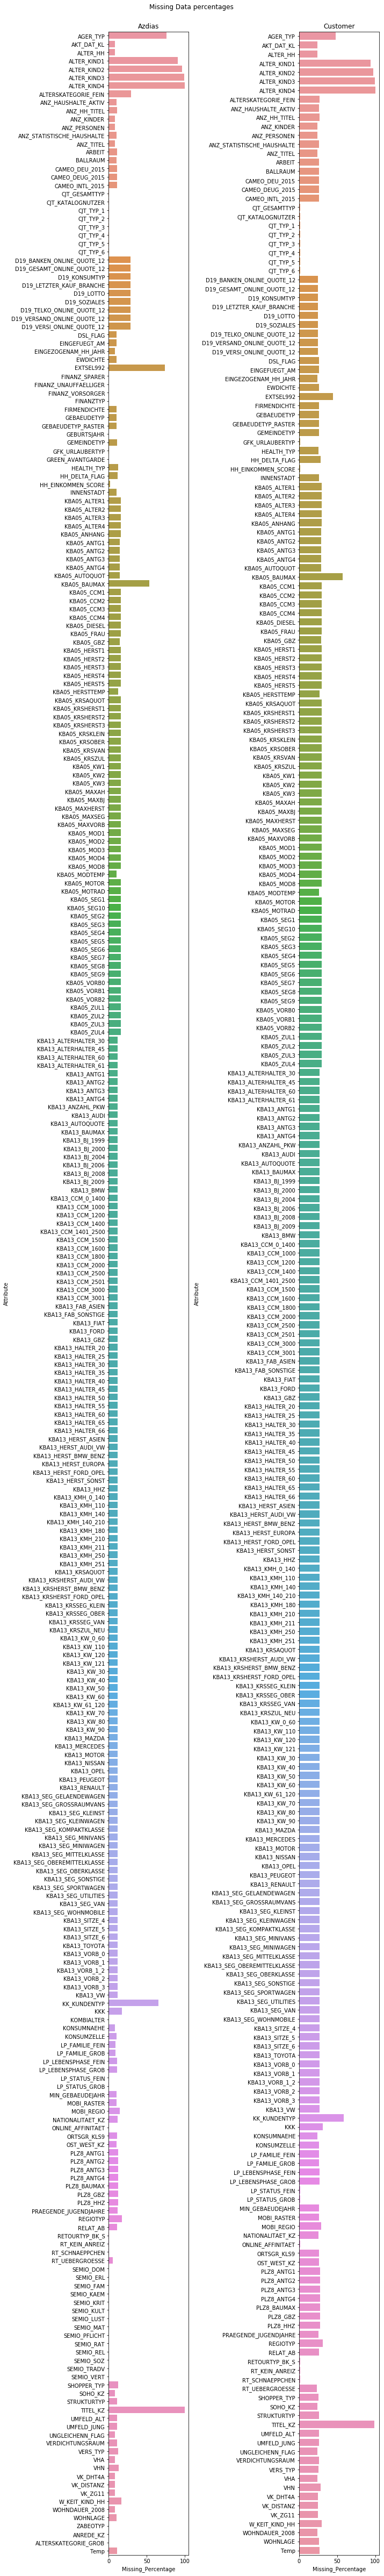

In [75]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

* There is overlap in both Azdias and Customers data i.e. data is missing from same columns.
* We now can threshold the missing percentage as 30 and see how many columns have missing data percentage more than the threshold.

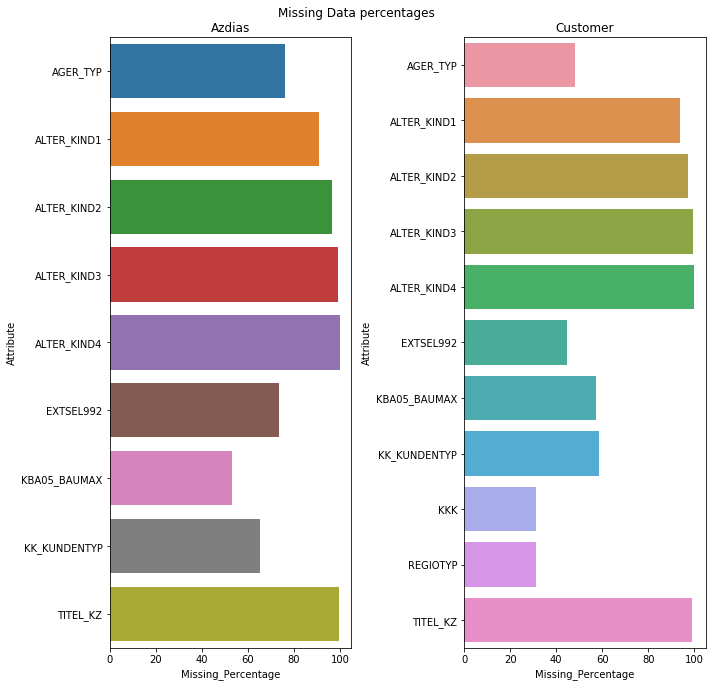

In [76]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

* We have 11 features with more more than 30% missing values in Customer data, where as in Azdias data we only have 9 feature. However, in total we had 279 columns with missing values in both dataframes.
* So 11 and 9 are considerably less number of features when compared to 279 and we can drop them.

* Our next step is to remove the features with more than 30% of data from Customer data, also the same features have to be removed from Azdias data.

In [77]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [78]:
print("Number of columns Before dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

azdias, customers, removed_cols = remove_missing_columns(azdias, customers, customer_missing_report, azdias_missing_report)

print("Number of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns Before dropping
Azdias - 367
Customers - 370
		Removed 11 columns from given dataframes
Number of columns After dropping
Azdias - 356
Customers - 359


### Missing values Row-wise

* After removing the columns which have more than 30% missing values, now we can look at the dataframes with remaining features for any missing values in rows.

In [79]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

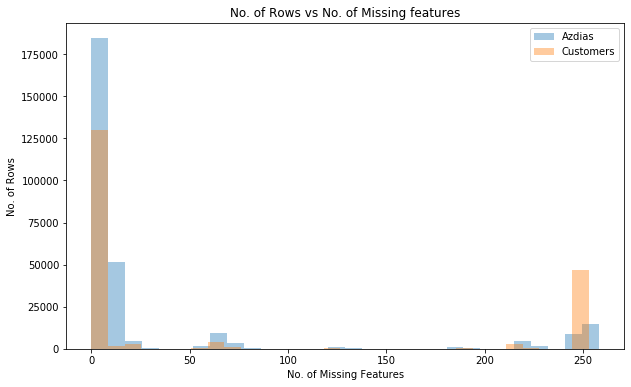

In [80]:
plot_missing_rowwise_histogram(azdias, customers)

* Most of the rows have only a few missing values in both dataframes.
* Customers data has comparatively less missing rows than Azdias.
* We can drop all the rows which have more than 50 missing values.

In [81]:
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [82]:
print("Number of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Number of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Number of rows Before dropping
Azdias - 290399
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 49285 rows from  dataframe
Number of rows After dropping
Azdias - 241114
Customers - 134246


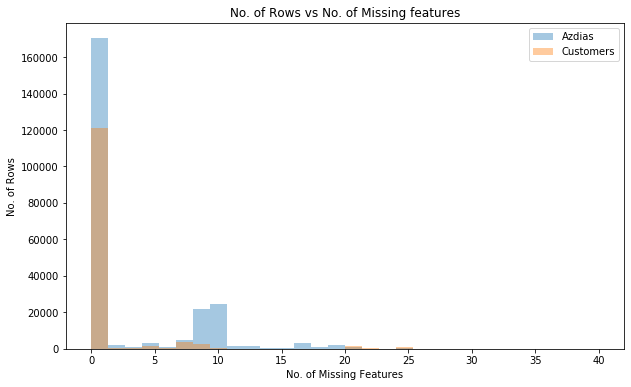

In [83]:
plot_missing_rowwise_histogram(azdias, customers)

As seen in the above plot we have successfully removed all the rows having more than 50 missing features. But, we still have some missing values in range of 1 to 50. We can impute most common values of corresponding features in these rows, as the data represents the demographics of population. We can make an assumption that these missing values will be equal to the most common ones.

# Part 2: Data Preprocessing (categorical data re-encoding and data scaling)

### Column Types

In [84]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241114 entries, 0 to 241113
Columns: 356 entries, LNR to Temp
dtypes: float64(290), int64(63), object(3)
memory usage: 654.9+ MB


In [85]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 359 entries, LNR to Temp
dtypes: float64(266), int64(88), object(5)
memory usage: 367.7+ MB


* There are three and five columns with dtype - object in azdias and customers datasets, respectively, we can look at the unique values in these columns.

In [86]:
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]

In [87]:
print("Azdias columns with dtype Object \n",azdias_object_cols.values)
print("Customer columns with dtype Object \n",customer_object_cols.values)

Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']
Customer columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ' 'PRODUCT_GROUP'
 'CUSTOMER_GROUP']


In [88]:
for col in azdias_object_cols:
    print("\nColumn ",col)
    print(azdias[col].value_counts())


Column  CAMEO_DEU_2015
6B    17846
8A    16607
4C    14461
3C    10900
2D    10836
7A    10726
3D    10308
8B    10167
4A    10123
8C     9682
9D     8773
9B     8163
7B     7489
9C     7478
9A     6543
2C     5763
8D     5263
6E     4915
5D     4603
2B     4568
6C     4544
2A     3987
1D     3821
1A     3339
5B     3309
5A     3184
5C     2978
4B     2755
7C     2726
4D     2580
6A     2074
3B     1944
3A     1920
6D     1842
6F     1668
4E     1651
1E     1531
7D     1509
7E     1362
1C     1327
1B     1294
5F     1264
9E     1238
5E     1069
XX       86
Name: CAMEO_DEU_2015, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             58575
D19_VERSICHERUNGEN        17006
D19_SONSTIGE              13449
D19_VOLLSORTIMENT         10283
D19_SCHUHE                 9354
D19_BUCH_CD                8311
D19_VERSAND_REST           7671
D19_DROGERIEARTIKEL        7014
D19_BANKEN_DIREKT          6823
D19_BEKLEIDUNG_REST        6267
D19_HAUS_DEKO              6051
D19_TELKO_MOBIL

Note: OST_WEST_KZ - contains information about the history of the person i.e. which part of Germany they belonged to before unification. We can encode values in this column with pd_dummies or a label encoder.

The columns that can be removed as they have too much granularity in information they represent. This will increase the number of features for modeling purposes. So these columns can also be dropped for simplicity:
* D19_LETZTER_KAUF_BRANCHE - contains information about the last branch they made a purchase.
* CAMEO_DEU_2015 - Gives information about specific group a person belongs to.

In [89]:
remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

azdias = remove_columns(azdias, remove_extra_cols)
customers = remove_columns(customers, remove_extra_cols)

### Encoding Categorical Columns

* Encoding OST_WEST_KZ column

In [90]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [91]:
azdias = fix_ost_west_col(azdias)
customers = fix_ost_west_col(customers)

* Ecoding ANREDE_KZ column

In [92]:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

In [93]:
azdias = fix_anrede_col(azdias)
customers = fix_anrede_col(customers)

* Encoding CAMEO_INTL_2015 column

In [94]:
azdias['CAMEO_INTL_2015'].unique()

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 41., 34., 55., 33.,
       25., nan, 23., 31., 52., 45., 35., 44., 32.])

In [95]:
customers['CAMEO_INTL_2015'].unique()

array([13., 34., 24., 41., 23., 15., 55., 14., 22., 51., 43., 33., 25.,
       44., 54., 32., 12., 35., 31., 45., 52., nan])

In [96]:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [97]:
azdias = fix_cameo_intl_col(azdias)
customers = fix_cameo_intl_col(customers)

In [98]:
azdias['CAMEO_INTL_2015_FAMILY'].unique()

array([ 1.,  4.,  2.,  3.,  5., nan])

In [99]:
azdias['CAMEO_INTL_2015_WEALTH'].unique()

array([ 5.,  2.,  1.,  4.,  3., nan])

* Fixing WOHNLAGE column
The column WOHNLAGE contains value - 0 for - no score calculated, while all other values represent some score. This value can be replaced with NaN.

In [100]:
azdias.WOHNLAGE.value_counts()

3.0    76244
7.0    52509
4.0    41966
2.0    31482
5.0    22247
1.0    13704
8.0     2957
0.0        5
Name: WOHNLAGE, dtype: int64

In [101]:
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

In [102]:
azdias = fix_wohnlage_col(azdias)
customers = fix_wohnlage_col(customers)

* Seperating customers dataframe into two parts, i.e. taking out the extra columns present in customers dataset as a separate dataframe.

In [103]:
customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

In [104]:
customer_extra_cols

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,COSMETIC_AND_FOOD,MULTI_BUYER,0
2,COSMETIC,MULTI_BUYER,0
3,FOOD,MULTI_BUYER,0
4,COSMETIC_AND_FOOD,MULTI_BUYER,0
...,...,...,...
134241,COSMETIC_AND_FOOD,MULTI_BUYER,0
134242,COSMETIC,SINGLE_BUYER,0
134243,COSMETIC_AND_FOOD,MULTI_BUYER,0
134244,FOOD,SINGLE_BUYER,0


Finally checking the shapes of all the dataframes.

In [105]:
azdias.shape, customers.shape, customer_extra_cols.shape

((241114, 353), (134246, 353), (134246, 3))

## Imputing missing values

Although we dropped columns and rows with missing values based on some threshold. We still have some columns having missing values. We can now address these missing values by either filling them with the mean of the values or most common values.

In this case, imputing missing values with most common values will make sense as this is demographic data and the values that are most common represent the population.

In [106]:
azdias.isna().sum()

LNR                                0
AKT_DAT_KL                         0
ALTER_HH                           0
ALTERSKATEGORIE_FEIN           54890
ANZ_HAUSHALTE_AKTIV                0
ANZ_HH_TITEL                    1090
ANZ_KINDER                         0
ANZ_PERSONEN                       0
ANZ_STATISTISCHE_HAUSHALTE         0
ANZ_TITEL                          0
ARBEIT                          1287
BALLRAUM                         127
CAMEO_DEUG_2015                  984
CJT_GESAMTTYP                   1458
CJT_KATALOGNUTZER               1458
CJT_TYP_1                       1458
CJT_TYP_2                       1458
CJT_TYP_3                       1458
CJT_TYP_4                       1458
CJT_TYP_5                       1458
CJT_TYP_6                       1458
D19_BANKEN_ANZ_12                  0
D19_BANKEN_ANZ_24                  0
D19_BANKEN_DATUM                   0
D19_BANKEN_DIREKT                  0
D19_BANKEN_GROSS                   0
D19_BANKEN_LOKAL                   0
D

In [107]:
customers.isna().sum()

LNR                               0
AKT_DAT_KL                        0
ALTER_HH                          0
ALTERSKATEGORIE_FEIN           4493
ANZ_HAUSHALTE_AKTIV               0
ANZ_HH_TITEL                   2025
ANZ_KINDER                        0
ANZ_PERSONEN                      0
ANZ_STATISTISCHE_HAUSHALTE        0
ANZ_TITEL                         0
ARBEIT                          521
BALLRAUM                         26
CAMEO_DEUG_2015                 300
CJT_GESAMTTYP                  3026
CJT_KATALOGNUTZER              3026
CJT_TYP_1                      3026
CJT_TYP_2                      3026
CJT_TYP_3                      3026
CJT_TYP_4                      3026
CJT_TYP_5                      3026
CJT_TYP_6                      3026
D19_BANKEN_ANZ_12                 0
D19_BANKEN_ANZ_24                 0
D19_BANKEN_DATUM                  0
D19_BANKEN_DIREKT                 0
D19_BANKEN_GROSS                  0
D19_BANKEN_LOKAL                  0
D19_BANKEN_OFFLINE_DATUM    

In [108]:
customer_extra_cols.isna().sum()

PRODUCT_GROUP      0
CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
dtype: int64

In [109]:
imputer = SimpleImputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [110]:
azdias.shape, customers.shape, customer_extra_cols.shape

((241114, 353), (134246, 353), (134246, 3))

## Data Cleaning function

All the above data cleaning steps could be organized into one single function before proceeding to further steps.  We could load the raw data into this function for data cleaning with full replication. 

In [111]:
def load_raw():
    # Reload attribute values but ignoring "Unnamed" column 
    no_unamed = lambda x: 'Unnamed' not in x
    attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
    attributes_info = pd.read_excel('./data/Input/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)
    azdias = pd.read_csv('./data/Input/Udacity_AZDIAS_052018.csv', sep=';', usecols=no_unamed)
    customers = pd.read_csv('./data/Input/Udacity_CUSTOMERS_052018.csv', sep=';',usecols=no_unamed)
    return attributes_values, attributes_info, azdias, customers

In [112]:
def clean_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50):
    
    print("Cleaning in Progress...")
    
    start = time.time()
    
    cleaning_info = {}
    
    extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    #attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(azdias.columns[18:20])
    
    customers = change_cameo_cols(customers)
    azdias = change_cameo_cols(azdias)
        
        
    print("\tFixing LP_* columns")
    customers = restructure_LP_cols(customers)
    azdias = restructure_LP_cols(azdias)
    
    print("\tFixing EINGEFUGT column")
    customers = change_eigefugt_col(customers)
    azdias = change_eigefugt_col(azdias)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"].dropna()
    
    azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=False)
    customers = replace_unkowns(customers, unkown_attributes_values, verbose=False)
    
    # Missing Values
    
    # Columns with missing values
    print(f"\tRemoving columns with more than {column_miss_perc} % missing values")
    customer_missing_report = get_missing_report(customers)
    azdias_missing_report = get_missing_report(azdias)
    
    azdias, customers, removed_cols = remove_missing_columns(azdias, customers, 
                                               customer_missing_report,
                                               azdias_missing_report,
                                              threshold=column_miss_perc)
    
    
    
    # Rows with missing values
    print(f"\tRemoving rows with more than {row_miss_count} missing values")
    customers = remove_missing_rows(customers, threshold=row_miss_count, name="Customers")
    azdias = remove_missing_rows(azdias, threshold=row_miss_count, name="Azdias")
    
    
    # Columns with no relevant information of which are too granular
    print("\tRemoving unwanted Columns")
    remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]
    removed_cols += remove_extra_cols
         
    azdias = remove_columns(azdias, remove_extra_cols)
    customers = remove_columns(customers, remove_extra_cols)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    azdias = fix_ost_west_col(azdias)
    customers = fix_ost_west_col(customers)
    
    print("\tEncoding ANREDE Column")
    azdias = fix_anrede_col(azdias)
    customers = fix_anrede_col(customers)
    
    print("\tEncoding CAMEO_INT column")
    azdias = fix_cameo_intl_col(azdias)
    customers = fix_cameo_intl_col(customers)
    
    print("\tEncoding WOHNLAGE column")
    azdias = fix_wohnlage_col(azdias)
    customers = fix_wohnlage_col(customers)
    
    # Separating customers dataset
    customers_additional = customers[extra_cols_in_customers]
    customers = customers.drop(extra_cols_in_customers, axis = 1)
        
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")

    azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
    customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)
    
    
    cleaning_info["Removed_cols"] = removed_cols   
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return azdias, customers, customers_additional, cleaning_info

In [113]:
# Check for these two functions
attributes_values, attributes_info, azdias, customers = load_raw()
azdias_cleaned, customers_cleaned, customers_additional_cleaned, cleaning_info = clean_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Cleaning in Progress...
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Removing columns with more than 30 % missing values
		Removed 11 columns from given dataframes
	Removing rows with more than 50 missing values
		Removed 57406 rows from Customers dataframe
		Removed 49285 rows from Azdias dataframe
	Removing unwanted Columns
	Encoding OST_WEST_KZ column
	Encoding ANREDE Column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Imputing missing values with most frequent ones
Completed Cleaning in 71.1902015209198 seconds


In [114]:
# Sanitory check 
azdias_cleaned.shape, customers_cleaned.shape, customers_additional_cleaned.shape

((241114, 353), (134246, 353), (134246, 3))

# save this data to a local directory

In [115]:
files_cleaned_dir = 'data/cleaned'

if not os.path.exists(files_cleaned_dir):
    os.makedirs(files_cleaned_dir)
    
azdias_cleaned.to_csv('./data/cleaned/Azdias_cleaned.csv', index=False)
customers_cleaned.to_csv('./data/cleaned/Customers_cleaned.csv', index=False)
customers_additional_cleaned.to_csv('./data/cleaned/Customer_Additional_cleaned.csv', index=False)

In [187]:
def load_cleaned(): 
    attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1)
    attributes_info = pd.read_excel('./data/Input/DIAS Information Levels - Attributes 2017.xlsx', header=1)
    azdias = pd.read_csv('./data/cleaned/Azdias_cleaned.csv', sep=',')
    customers = pd.read_csv('./data/cleaned/Customers_cleaned.csv', sep=',')
    customers_additional = pd.read_csv('./data/cleaned/Customer_Additional_cleaned.csv', sep=',')
    return attributes_values, attributes_info, azdias, customers, customers_additional

In [188]:
attributes_attributes, attributes_info, azdias_cleaned, customers_cleaned, customers_additional_cleaned = load_cleaned()

In [189]:
# Sanitory check 
azdias_cleaned.shape, customers_cleaned.shape, customers_additional_cleaned.shape

((241114, 353), (134246, 353), (134246, 3))

* Column LNR corresponds to id of each person and not a feature. We can drop this column for further analysis. 

In [190]:
azdias_cleaned = azdias_cleaned.drop("LNR", axis=1)
customers_cleaned = customers_cleaned.drop("LNR", axis=1)

## Feature Scaling 

* Standardizing the scale of the numerical columns in order to consistently compare the values of different features. We will use a StandardScaler to transform the numerical values so that they have the same range.

In [191]:
# scale numerical features 
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns, index = azdias_cleaned.index)
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned), columns = customers_cleaned.columns, index = customers_cleaned.index)

In [192]:
azdias_scaled

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,1.259814,-1.434149,1.561893,0.190422,-0.124437,-0.301247,0.218853,0.342117,-0.060155,-0.158990,...,1.444672,-0.741360,0.548627,-0.024663,1.145195,0.956843,-1.676427,0.448662,1.174229,-1.250353
1,1.259814,0.797345,0.673033,0.123911,-0.124437,-0.301247,-0.633778,-0.028879,-0.060155,-0.158990,...,0.012817,-0.741360,0.548627,-1.079293,1.145195,0.956843,0.168611,-0.993454,-0.871690,0.768488
2,-0.936226,0.272287,-0.215827,-0.474689,-0.124437,-0.301247,-1.486409,-0.399876,-0.060155,-1.161990,...,1.802635,0.955435,0.548627,1.557283,-0.274060,0.956843,1.091130,-1.153689,-1.553663,-0.577406
3,-0.936226,1.191138,0.006388,-0.341667,-0.124437,-0.301247,1.924115,-0.325676,-0.060155,0.844011,...,-0.703111,-1.306958,0.548627,-0.551978,0.435567,-1.045103,0.168611,1.329955,0.492256,0.095541
4,-0.936226,-0.121506,-0.882472,-0.208645,-0.124437,-0.301247,-0.633778,-0.399876,-0.060155,-1.161990,...,-0.703111,0.955435,0.548627,1.557283,0.435567,0.956843,-1.676427,-0.592866,1.174229,0.768488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241109,-0.936226,-1.434149,0.228603,1.387624,-0.124437,-0.301247,-0.633778,1.232508,-0.060155,-1.161990,...,0.370781,0.389837,-1.039471,-0.551978,-0.274060,-1.045103,0.168611,-0.833218,-0.189717,0.768488
241110,0.161794,-1.434149,0.228603,-0.142133,-0.124437,-0.301247,-0.633778,-0.177278,-0.060155,0.844011,...,0.728744,-0.175762,-2.627569,-1.079293,-0.274060,0.956843,0.168611,-0.672983,-0.871690,0.768488
241111,1.259814,0.928609,0.895248,0.589489,-0.124437,-0.301247,-0.633778,0.935711,-0.060155,0.844011,...,0.370781,0.955435,0.548627,-0.551978,1.145195,-1.045103,-0.753908,-1.153689,1.174229,-1.250353
241112,1.259814,0.797345,0.673033,1.786691,-0.124437,-0.301247,-0.633778,1.974500,-0.060155,-0.158990,...,0.728744,0.389837,0.548627,-0.024663,1.145195,-1.045103,-1.676427,-0.913336,1.174229,-1.250353


In [193]:
customers_scaled

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,-0.367858,-0.216129,-0.100224,-0.274802,-0.12496,-0.265318,-0.207283,-0.257866,-0.134726,-1.813374,...,-0.512591,0.867545,0.273904,1.583686,0.462491,-0.699527,0.651177,-0.214573,-1.132524,-0.273513
1,-0.367858,-0.855203,-2.529358,-0.274802,-0.12496,-0.265318,-0.921821,-0.257866,-0.134726,0.164231,...,3.420572,0.867545,0.273904,-0.836801,0.462491,1.429537,0.651177,-0.740635,0.287206,0.470972
2,-0.367858,-0.535666,-0.586051,-0.347719,-0.12496,-0.265318,-1.636359,-0.257866,-0.134726,-1.813374,...,-0.512591,0.867545,0.273904,1.583686,-1.073113,-0.699527,0.651177,-1.642455,-0.422659,0.470972
3,-0.367858,1.381556,0.871429,0.162700,-0.12496,-0.265318,1.221792,0.185989,-0.134726,0.164231,...,0.361445,-1.281187,0.273904,-0.352704,-1.073113,-0.699527,-0.670733,0.612095,0.997072,-1.762483
4,-0.367858,-0.056360,-0.100224,-0.274802,-0.12496,-0.265318,-0.207283,-0.257866,-0.134726,0.164231,...,-0.949609,0.867545,0.273904,-1.320899,-0.305311,-0.699527,-0.670733,-0.440028,0.287206,0.470972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134241,-0.367858,-0.375897,-0.343138,-0.274802,-0.12496,-0.265318,-0.921821,-0.257866,-0.134726,0.164231,...,0.798463,0.867545,0.273904,-1.320899,0.462491,-0.699527,-0.670733,-1.041241,-1.132524,0.470972
134242,0.155422,-1.813814,-2.529358,-0.347719,-0.12496,-0.265318,-1.636359,-0.257866,-0.134726,-1.813374,...,0.361445,0.867545,0.273904,-0.352704,0.462491,1.429537,0.651177,-1.642455,0.287206,-1.017998
134243,-0.367858,0.582714,-0.100224,-0.274802,-0.12496,-0.265318,0.507254,-0.257866,-0.134726,0.164231,...,0.798463,-0.744004,0.273904,-0.352704,0.462491,-0.699527,0.651177,1.288460,-0.422659,0.470972
134244,-0.367858,0.263177,0.628516,-0.056051,-0.12496,-0.265318,1.221792,-0.109914,-0.134726,0.164231,...,-0.949609,-0.206821,0.273904,-0.836801,0.462491,1.429537,-0.670733,0.687247,-0.422659,0.470972


# Part 3: Feature Engineering

## Dimensionality Reduction by PCA

First, specify where to save the model training data, the output_path.

In [194]:
# define a location to store model artifacts
prefix = 'Arvato/Output'

output_path='s3://{}/{}/'.format(bucket, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/Arvato/Output/


In [195]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS= azdias_scaled.shape[1] -1 

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=sagemaker_session)

Convert data into a RecordSet format
* The record_set function in the SageMaker PCA model converts a numpy array into a RecordSet format that is the required format for the training input data. This is a requirement for all of SageMaker's built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, especially for large datasets.

In [196]:
# convert df to np array
train_data_np = azdias_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [197]:
train_data_np

array([[ 1.2598137 , -1.4341494 ,  1.5618927 , ...,  0.448662  ,
         1.1742294 , -1.2503526 ],
       [ 1.2598137 ,  0.7973447 ,  0.67303276, ..., -0.9934535 ,
        -0.8716896 ,  0.7684881 ],
       [-0.93622625,  0.27228722, -0.21582727, ..., -1.1536885 ,
        -1.5536627 , -0.5774057 ],
       ...,
       [ 1.2598137 ,  0.928609  ,  0.89524776, ..., -1.1536885 ,
         1.1742294 , -1.2503526 ],
       [ 1.2598137 ,  0.7973447 ,  0.67303276, ..., -0.913336  ,
         1.1742294 , -1.2503526 ],
       [-0.93622625, -1.4341494 ,  0.22860274, ..., -1.1536885 ,
         1.1742294 , -1.2503526 ]], dtype=float32)

### Train the model

Call the fit function on the PCA model, passing in our formatted, training data. This spins up a training instance to perform the training job.

In [198]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-25 02:56:36 Starting - Starting the training job...
2020-10-25 02:56:38 Starting - Launching requested ML instances......
2020-10-25 02:57:51 Starting - Preparing the instances for training......
2020-10-25 02:59:00 Downloading - Downloading input data...
2020-10-25 02:59:24 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/25/2020 02:59:48 INFO 140137181820736] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/25/2020 02:59:48 INFO 140137181820736] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'352', u'mini_batch_size': u'500', u'num_com

### Accessing the PCA Model Attributes

Unzip and retrieve the model details

In [202]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-10-25-02-56-36-264'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Arvato/Output/pca-2020-10-25-02-56-36-264/output/model.tar.gz


2304

MXNet Array
* Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

In [203]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[  51.45667    57.294647   61.994106   68.68316    72.213196   79.25547
   82.620026   85.37982    92.75684    96.273636  102.62434   103.59491
  104.16739   105.09708   113.106895  114.8443    120.28812   127.70213
  128.75899   129.86676   131.05717   132.28772   133.92633   134.07469
  135.01183   135.5355    136.64297   137.14954   138.44333   139.76257
  140.0968    140.7073    142.41893   143.67134   144.39877   145.43784
  146.0368    147.20087   149.23053   149.55832   151.74019   152.87991
  153.09232   155.11833   157.34091   157.44566   157.79495   159.87865
  160.65639   162.08269   162.95746   163.77223   163.94342   164.81451
  165.35918   165.85266   165.97346   166.45584   167.37761   171.47273
  172.35814   173.7161    175.59042   175.97462   176.10973   177.02357
  178.24689   179.37907   180.74825   181.87657   182.9324    184.76227
  186.80408   187.34872   188.02301   192.89102   193.89467   194.89803
  196.61871   198.61783   199.10776   200.31097   202.533

### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

mean: The mean that was subtracted from a component in order to center it.
v: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
s: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
We are only interested in v and s.

From s, we can get an approximation of the data variance that is covered in the first n principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for all components

From v, we can learn more about the combinations of original features that make up each principal component.

In [204]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

### Data Variance

* Define a function to calculate for the smallest number of principal components that captures at least 80% of the total variance in the dataset

In [205]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

### Test Cell
* Test out your own code by seeing how it responds to different inputs

In [206]:
# test cell
n_top_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 121, 130] # select a value for the number of top components

# calculate the explained variance
for n in n_top_components:
    exp_variance = explained_variance(s, n)
    print('Explained variance: ', exp_variance)

Explained variance:  0.33757982
Explained variance:  0.43916684
Explained variance:  0.5076991
Explained variance:  0.56052625
Explained variance:  0.6038389
Explained variance:  0.6409748
Explained variance:  0.6732256
Explained variance:  0.702242
Explained variance:  0.728927
Explained variance:  0.754055
Explained variance:  0.77765965
Explained variance:  0.79985327
Explained variance:  0.80198634
Explained variance:  0.8206896


In [207]:
# original features
features_list = azdias_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['AKT_DAT_KL' 'ALTER_HH' 'ALTERSKATEGORIE_FEIN' 'ANZ_HAUSHALTE_AKTIV'
 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN' 'ANZ_STATISTISCHE_HAUSHALTE'
 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM' 'CAMEO_DEUG_2015' 'CJT_GESAMTTYP'
 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24'
 'D19_BANKEN_DATUM' 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS'
 'D19_BANKEN_LOKAL' 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAUS_DEKO'
 'D19_KINDERARTIKEL' 'D19_KONSUMTYP' 'D19_KONSUMTYP_MAX' 'D19_KOSMETIK'
 'D19_LEBENSMITTEL' 'D19_LOTTO' 'D19_NAHRUNGSERG

### Component Makeup
* We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component.

In [208]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

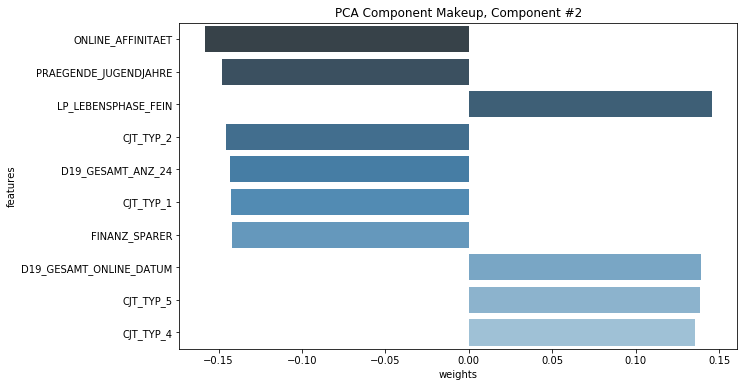

In [209]:
# display makeup of first component
num=2
display_component(v, azdias_scaled.columns.values, component_num=num, n_weights=10)

### Deploying the PCA Model
* Now deploy this model and use it to make "predictions". Instead of seeing what happens with some test data, our training data will be passed into the deployed endpoint to create principal components for each data point.

In [213]:
%%time

pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium',
                              endpoint_name='pca-v2')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: pca-2020-10-25-02-56-36-264


---------------------!CPU times: user 364 ms, sys: 18.4 ms, total: 383 ms
Wall time: 10min 33s


We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [214]:
azdias_cleaned

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,10.0,3.0,9.0,4.0,5.0,1.0,1.0,21.0,5.0,1.0
1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,6.0,3.0,9.0,2.0,5.0,1.0,3.0,3.0,2.0,4.0
2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,11.0,6.0,9.0,7.0,3.0,1.0,4.0,1.0,1.0,2.0
3,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,4.0,2.0,9.0,3.0,4.0,0.0,3.0,32.0,4.0,3.0
4,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,4.0,6.0,9.0,7.0,4.0,1.0,1.0,8.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241109,1.0,0.0,15.0,29.0,0.0,0.0,1.0,24.0,0.0,2.0,...,7.0,5.0,6.0,3.0,3.0,0.0,3.0,5.0,3.0,4.0
241110,5.0,0.0,15.0,6.0,0.0,0.0,1.0,5.0,0.0,4.0,...,8.0,4.0,3.0,2.0,3.0,1.0,3.0,7.0,2.0,4.0
241111,9.0,18.0,18.0,17.0,0.0,0.0,1.0,20.0,0.0,4.0,...,7.0,6.0,9.0,3.0,5.0,0.0,2.0,1.0,5.0,1.0
241112,9.0,17.0,17.0,35.0,0.0,0.0,1.0,34.0,0.0,3.0,...,8.0,5.0,9.0,4.0,5.0,0.0,1.0,4.0,5.0,1.0


In [227]:
train_data_np.shape

(241114, 352)

In [218]:
#train_data_set = train_data_np[:4000]

In [229]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/pca-v2/invocations".

# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

### Create a transformed DataFrame

# create dimensionality-reduced data
def create_transformed_df(train_pca, azdias_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    azdias_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        azdias_transformed=azdias_transformed.append([list(components)])

    
    azdias_transformed.index=azdias_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    azdias_transformed = azdias_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return azdias_transformed.iloc[:, ::-1]

Now we can create a dataset with the top n principle components analyzed earlier. Each of these components is a linear combination of the original feature space. We can interpret each of these components by analyzing the makeup of the component, shown previously.

# specify top n
top_n = 121

# call your function and create a new dataframe
azdias_transformed = create_transformed_df(train_pca, azdias_scaled[:4000], n_top_components=top_n)

# print result
azdias_transformed

Now that we've deployed the model and created our new, transformed training data

## Part 4: Customer segmentation with unsupervised machine leaning algorithm (e.g., K-means clusting)